# Resume selector using naive bayes 

Selecting the resume that are eligbile to data scientist postions, the dataset used contains 125 resumes, in the resumetext column. Resumes were queried from Indeed.com with keyword 'data scientist', location 'Vermont'. If a resume is 'not flagged', the applicant can submit a modified resume version at a later date. If it is 'flagged', the applicant is invited to interview.
The data can be downloaded from __[here](https://www.kaggle.com/samdeeplearning/deepnlp)__

### IMPORT LIBRARIES AND DATASETS

In [1]:
# install nltk
!pip install nltk

In [2]:
# install gensim
!pip install gensim

In [3]:
!pip install wordcloud

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 
# setting the style of the notebook to be monokai theme  
# this line of code is important to ensure that we are able to see the x and y axes clearly
# If you don't run this code line, you will notice that the xlabel and ylabel on any plot is black on black and it will be hard to see them. 


In [6]:
# load the data
resume_df = pd.read_csv('resume.csv', encoding = 'latin-1')
resume_df

,resume_id,class,resume_text
0,resume_1,not_flagged,\rCustomer Service Supervisor/Tier - Isabella ...
1,resume_2,not_flagged,\rEngineer / Scientist - IBM Microelectronics ...
2,resume_3,not_flagged,\rLTS Software Engineer Computational Lithogra...
3,resume_4,not_flagged,TUTOR\rWilliston VT - Email me on Indeed: ind...
4,resume_5,flagged,\rIndependent Consultant - Self-employed\rBurl...
...,...,...,...
120,resume_121,not_flagged,\rBrattleboro VT - Email me on Indeed: indeed....
121,resume_122,not_flagged,\rResearch and Teaching Assistant - University...
122,resume_123,not_flagged,\rMedical Coder - Highly Skilled - Entry Level...
123,resume_124,flagged,\rWaterbury VT - Email me on Indeed: indeed.co...


In [7]:
# data containing resume
resume_df = resume_df[['resume_text','class']]

In [8]:
#Print the first and last elements in the dataframe
resume_df.iloc[[0,-1],:]

,resume_text,class
0,\rCustomer Service Supervisor/Tier - Isabella ...,not_flagged
124,\rResearch and Development Scientist - Burling...,not_flagged


### EXPLORATORY DATA ANALYSIS

In [9]:
# obtain dataframe information
resume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   resume_text  125 non-null    object
 1   class        125 non-null    object
dtypes: object(2)
memory usage: 2.1+ KB


In [10]:
# check for null values
resume_df.isnull().sum()

resume_text    0
class          0
dtype: int64

In [11]:
resume_df['class'].value_counts()

not_flagged    92
flagged        33
Name: class, dtype: int64

In [12]:
resume_df['class'] = resume_df['class'].apply(lambda x:1 if x == 'flagged' else 0)
resume_df

C:\Users\Administrator\anaconda31\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,resume_text,class
0,\rCustomer Service Supervisor/Tier - Isabella ...,0
1,\rEngineer / Scientist - IBM Microelectronics ...,0
2,\rLTS Software Engineer Computational Lithogra...,0
3,TUTOR\rWilliston VT - Email me on Indeed: ind...,0
4,\rIndependent Consultant - Self-employed\rBurl...,1
...,...,...
120,\rBrattleboro VT - Email me on Indeed: indeed....,0
121,\rResearch and Teaching Assistant - University...,0
122,\rMedical Coder - Highly Skilled - Entry Level...,0
123,\rWaterbury VT - Email me on Indeed: indeed.co...,1


In [13]:
#Divide the DataFrame into two, one that belongs to class 0 and 1. Do we have a balanced dataset?
resume_df_0 = resume_df[resume_df['class']==0]
resume_df_1 = resume_df[resume_df['class']==1]
print('The number of 0 class',len(resume_df_0))
print('The number of 1 class',len(resume_df_1))

The number of 0 class 92
The number of 1 class 33


### DATA CLEANING

In [14]:
resume_df['resume_text'] = resume_df['resume_text'].apply(lambda x:x.replace('\r', ''))
resume_df

C:\Users\Administrator\anaconda31\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,resume_text,class
0,Customer Service Supervisor/Tier - Isabella Ca...,0
1,Engineer / Scientist - IBM Microelectronics Di...,0
2,LTS Software Engineer Computational Lithograph...,0
3,TUTORWilliston VT - Email me on Indeed: indee...,0
4,Independent Consultant - Self-employedBurlingt...,1
...,...,...
120,Brattleboro VT - Email me on Indeed: indeed.co...,0
121,Research and Teaching Assistant - University o...,0
122,Medical Coder - Highly Skilled - Entry LevelSu...,0
123,Waterbury VT - Email me on Indeed: indeed.com/...,1


In [15]:
# download nltk packages
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
# download nltk packages
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
# Get additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from','subject','reply','use','email','com'])

In [18]:
# Remove stop words and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return ' '.join(result)

In [19]:
# Cleaned text
resume_df['cleaned'] = resume_df['resume_text'].apply(preprocess)

In [20]:
print(resume_df['cleaned'][0])

customer service supervisor tier isabella catalog companysouth burlington aecf work service supervisor tierisabella catalog company shelburne august present customer service visual set display website maintenance supervise customer service team popular catalog company manage day day issues resolution customer upset ensure customer satisfaction troubleshoot order shipping issues lost transit order errors damages manage resolve escalated customer calls ensure customer satisfaction assist customers order placing cross selling upselling catalog merchandise set display sample merchandise catalog library customer pick area facility website clean adding images type product information assistant events coordinator office services assistanteileen fisher irvington february july support director architecture architecture coordinator daily activities including preparing monthly expense reports scheduling calendar maintenance arranging aspects travel logistics catering interior design research proj

In [21]:
print(resume_df['resume_text'][0])

Customer Service Supervisor/Tier - Isabella Catalog CompanySouth Burlington VT - Email me on Indeed: indeed.com/r//49f8c9aecf490d26WORK EXPERIENCECustomer Service Supervisor/TierIsabella Catalog Company - Shelburne VT - August 2015 to Present2 Customer Service/Visual Set Up & Display/Website Maintenance¢ Supervise customer service team of a popular catalog company¢ Manage day to day issues and resolution of customer upset to ensure customer satisfaction¢ Troubleshoot order and shipping issues: lost in transit order errors damages¢ Manage and resolve escalated customer calls to ensure customer satisfaction¢ Assist customers with order placing cross-selling/upselling of catalog merchandise¢ Set up and display of sample merchandise in catalog library as well as customer pick-up area of the facility ¢ Website clean-up: adding images type up product information proofreadingAdministrative Assistant /Events Coordinator/Office Services AssistantEileen Fisher Inc - Irvington NY - 

### VISUALIZE CLEANED DATASET

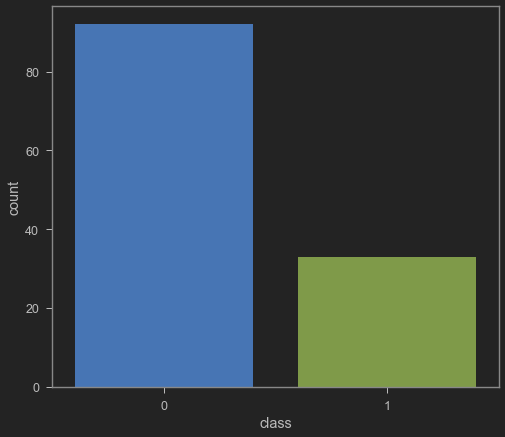

In [22]:
# Plot the counts of flagged vs not flagged
sns.countplot(resume_df['class'], label = 'Count Plot')

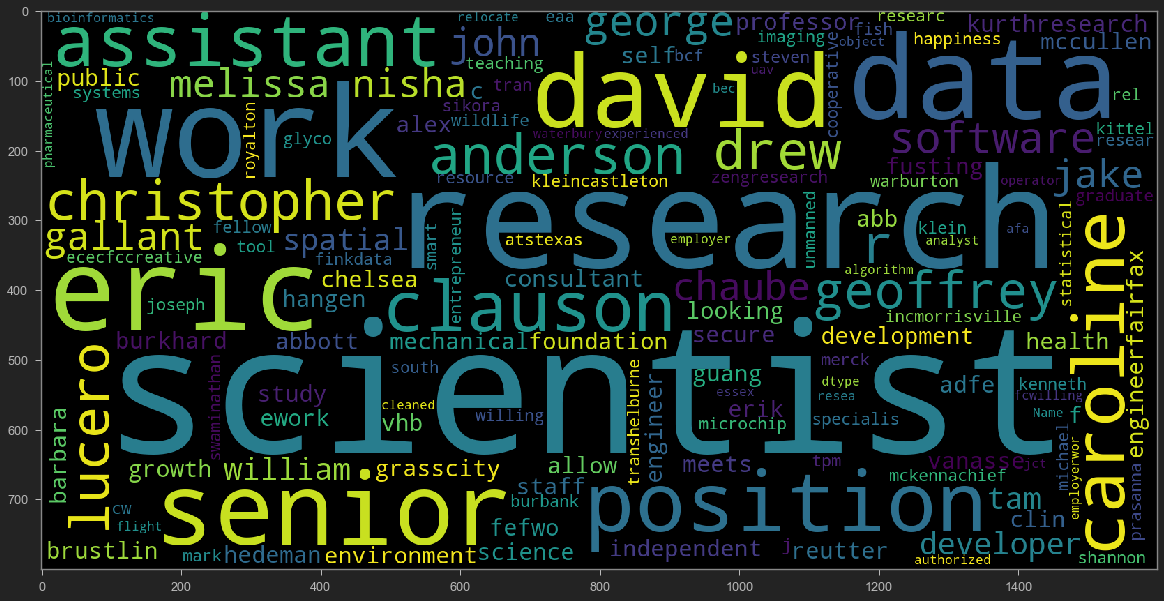

In [23]:
# plot the word cloud for text that is flagged
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000, width= 1600, height= 800, stopwords = stop_words).generate(str(resume_df[resume_df['class']==1].cleaned))
plt.imshow(wc)

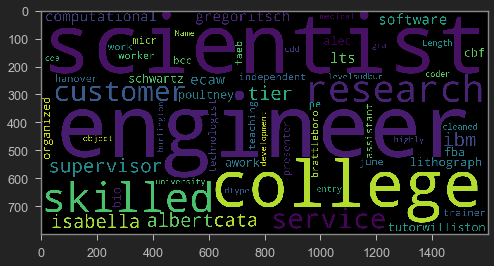

In [24]:
# Plot the wordcloud for class #0 
wc = WordCloud(max_words = 2000, width= 1600, height= 800, stopwords = stop_words).generate(str(resume_df[resume_df['class']==0].cleaned))
plt.imshow(wc)

### PREPARE THE DATA BY APPLYING COUNT VECTORIZER

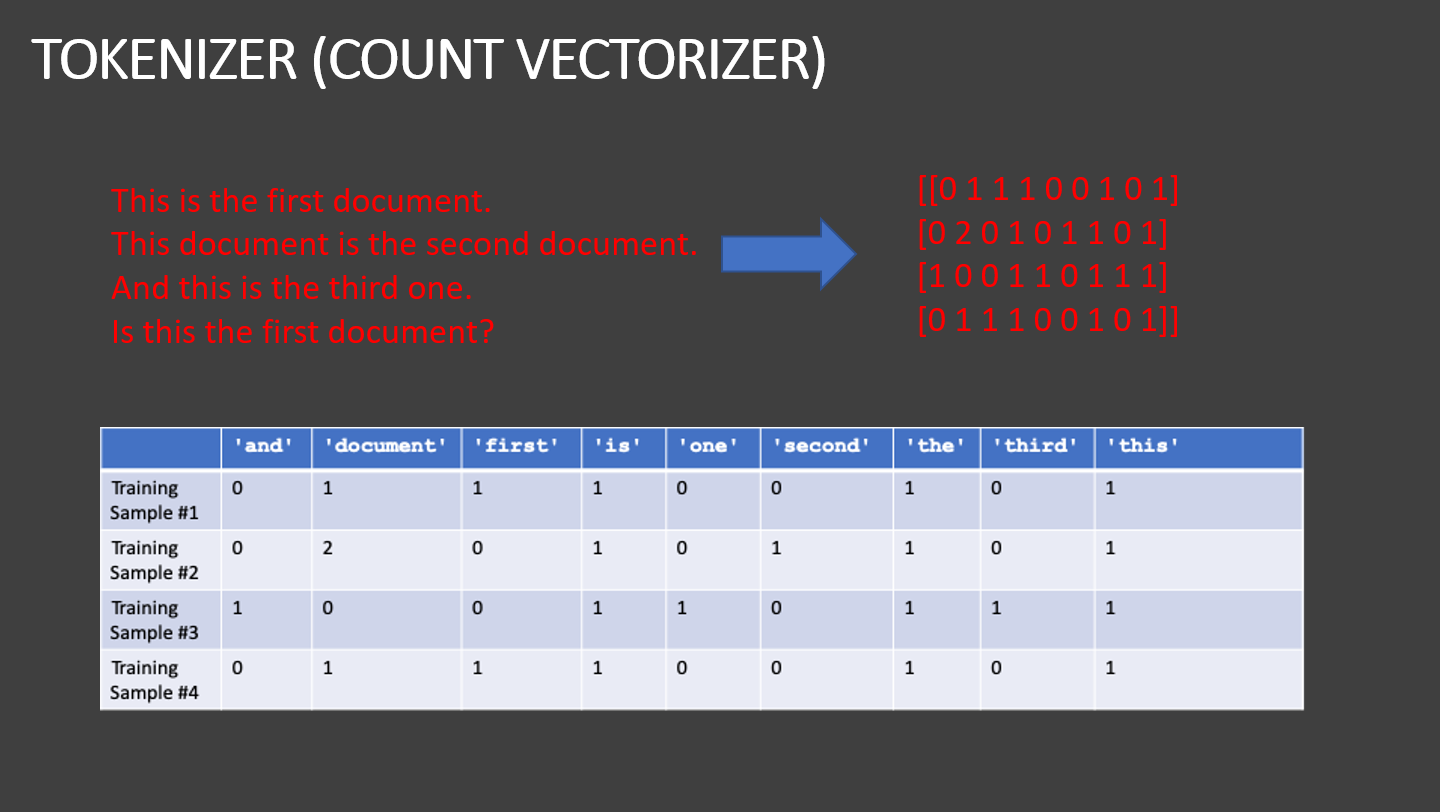

In [25]:
# CountVectorizer example
from sklearn.feature_extraction.text import CountVectorizer
sample_data = ['This is the first document.','This document is the second document.','And this is the third one.','Is this the first document?']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sample_data)

In [26]:
print(vectorizer.get_feature_names())

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']


In [27]:
print(X.toarray())

[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


In [28]:
# Applying CountVectorier to the cleaned text
vectorizer = CountVectorizer()
countvectorizer = vectorizer.fit_transform(resume_df['cleaned'])

In [29]:
print(vectorizer.get_feature_names())

['aaalac', 'aabb', 'aac', 'aacn', 'aacr', 'aacrjournals', 'aakeroõ_y', 'aanpcp', 'aaron', 'abbott', 'abdomen', 'abdominal', 'abdul', 'aberdeen', 'abi', 'abilities', 'ability', 'abiotic', 'able', 'abnormal', 'aboard', 'abosalem', 'abraham', 'abreast', 'abs', 'absence', 'absorbance', 'abstract', 'abstracta', 'abstractdisease', 'abstracted', 'abstractin', 'abstracts', 'abualrub', 'abundance', 'abureehan', 'abuse', 'abusiness', 'academia', 'academic', 'academics', 'academy', 'acaeefbc', 'accelerated', 'accept', 'acceptability', 'acceptable', 'acceptance', 'accepted', 'accepting', 'access', 'accessibility', 'accessible', 'accession', 'accident', 'accidents', 'accolateî', 'accommodations', 'accomplished', 'accomplishment', 'accomplishments', 'accord', 'accordance', 'according', 'accordingly', 'accords', 'account', 'accountability', 'accountable', 'accounted', 'accounting', 'accounts', 'accreditation', 'accredited', 'accrual', 'accumulation', 'accuracy', 'accurate', 'accurately', 'accustomed'

In [30]:
print(countvectorizer.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### UNDERSTAND THE THEORY AND INTUITION BEHIND NAIVE BAYES CLASSIFIERS 

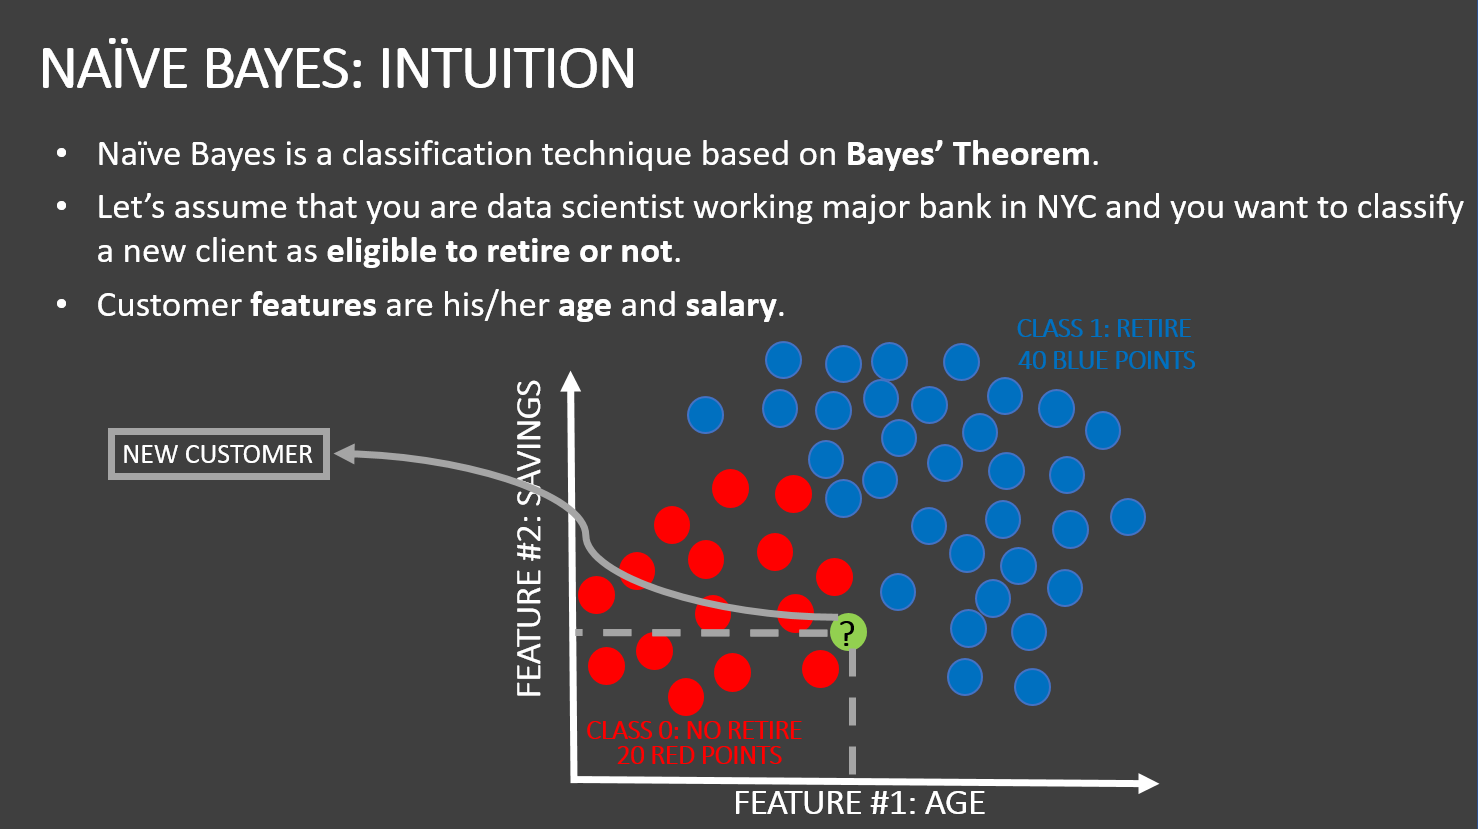

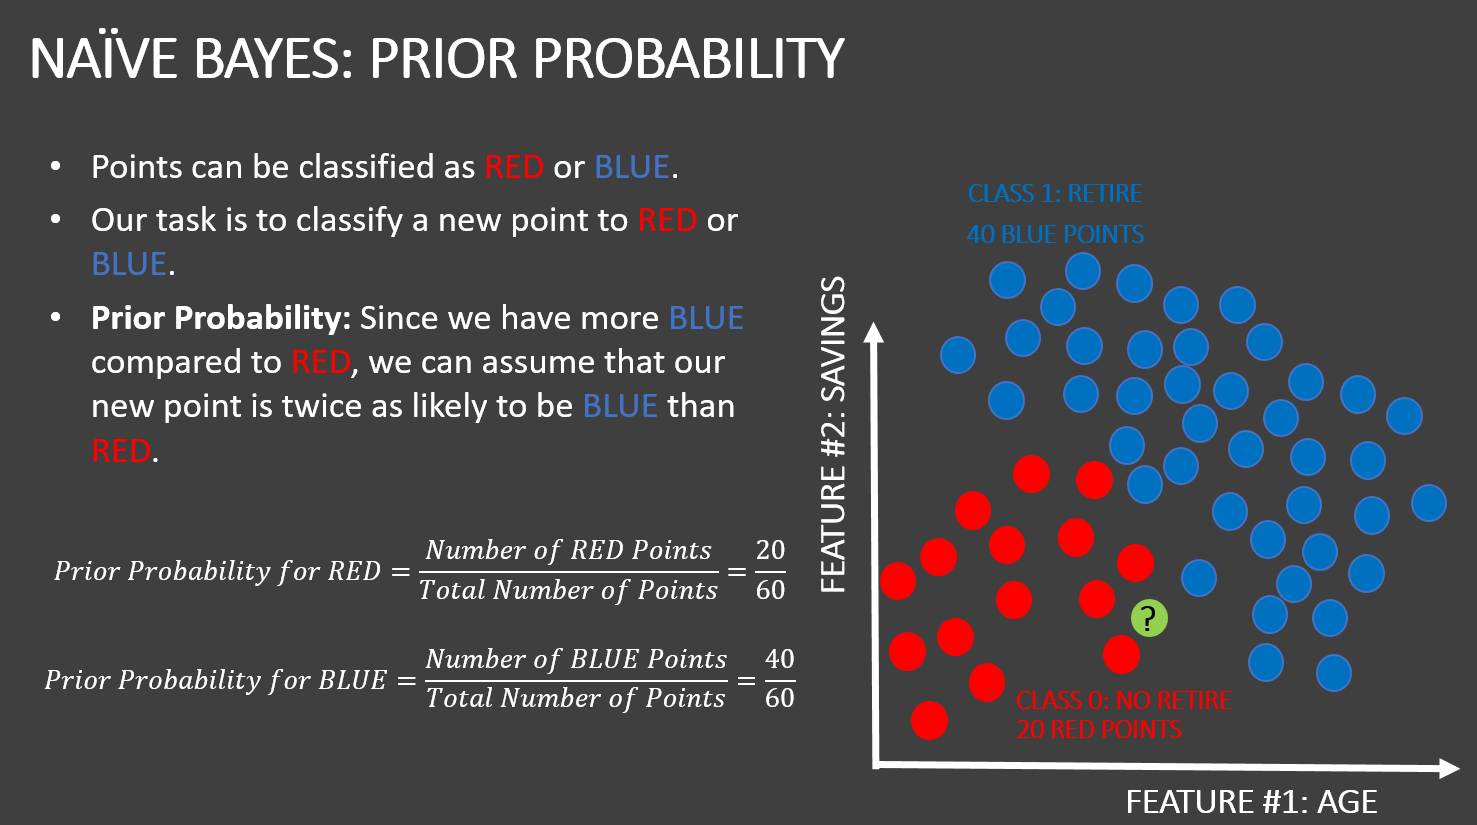

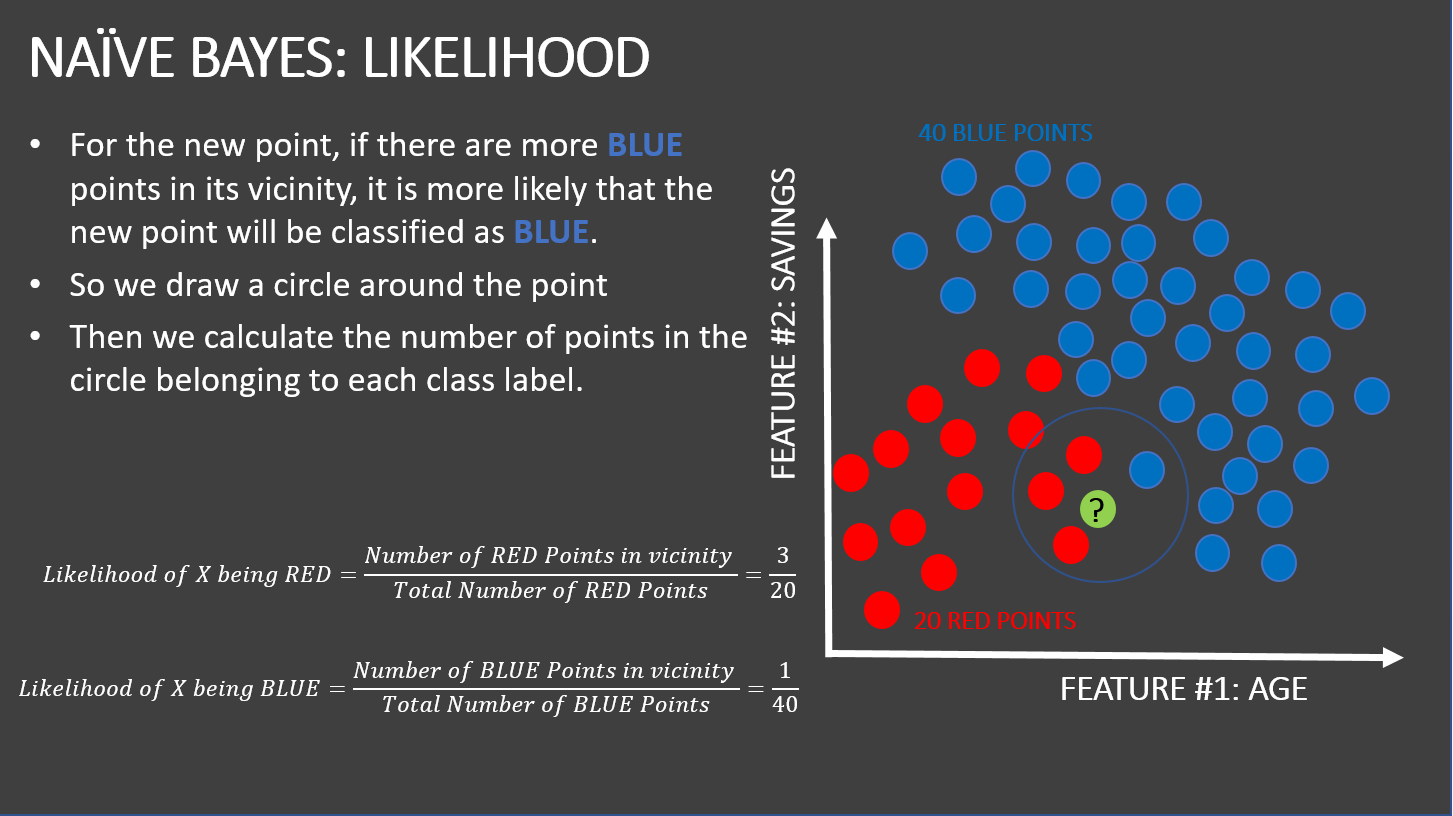

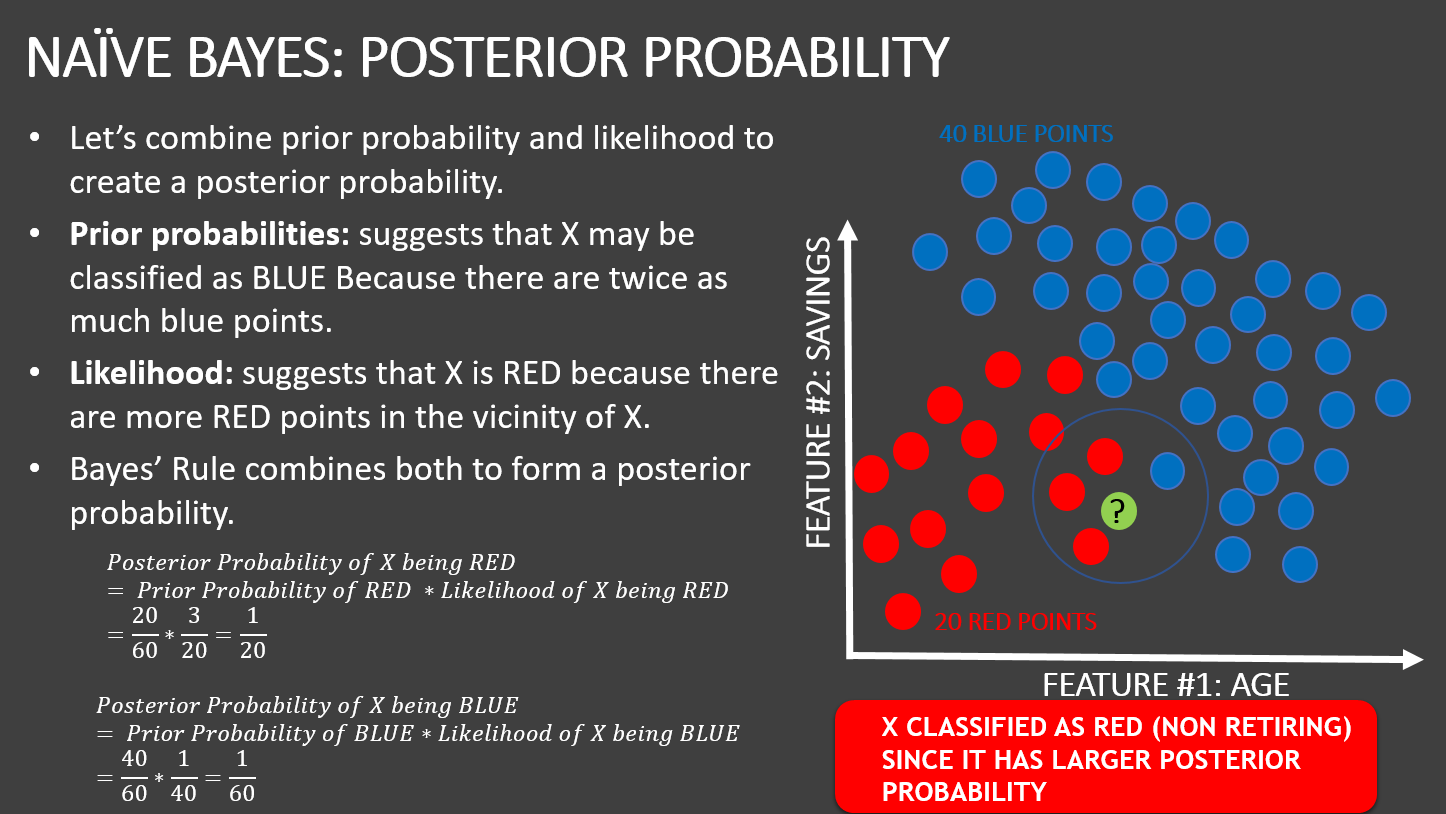

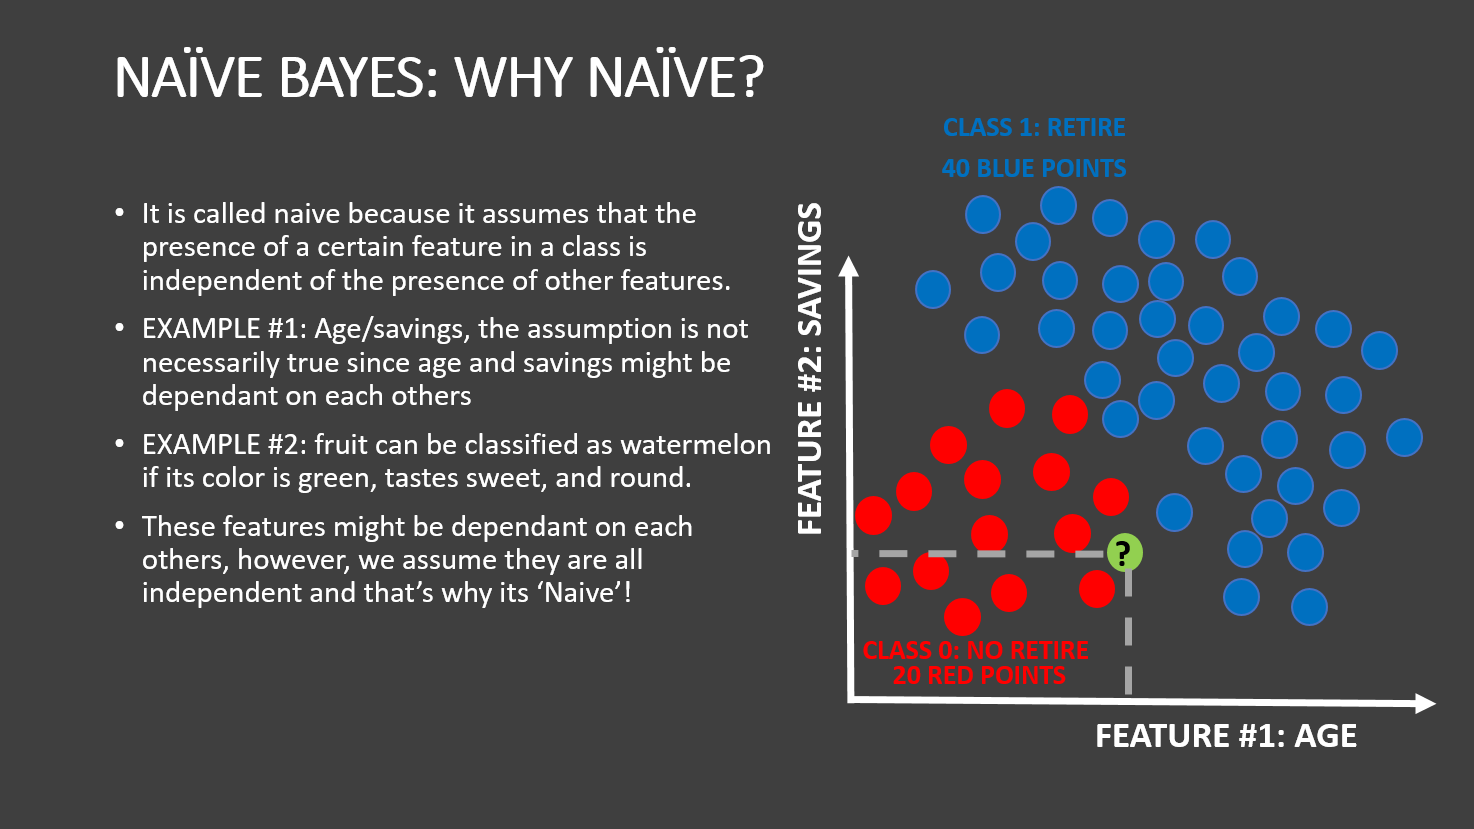

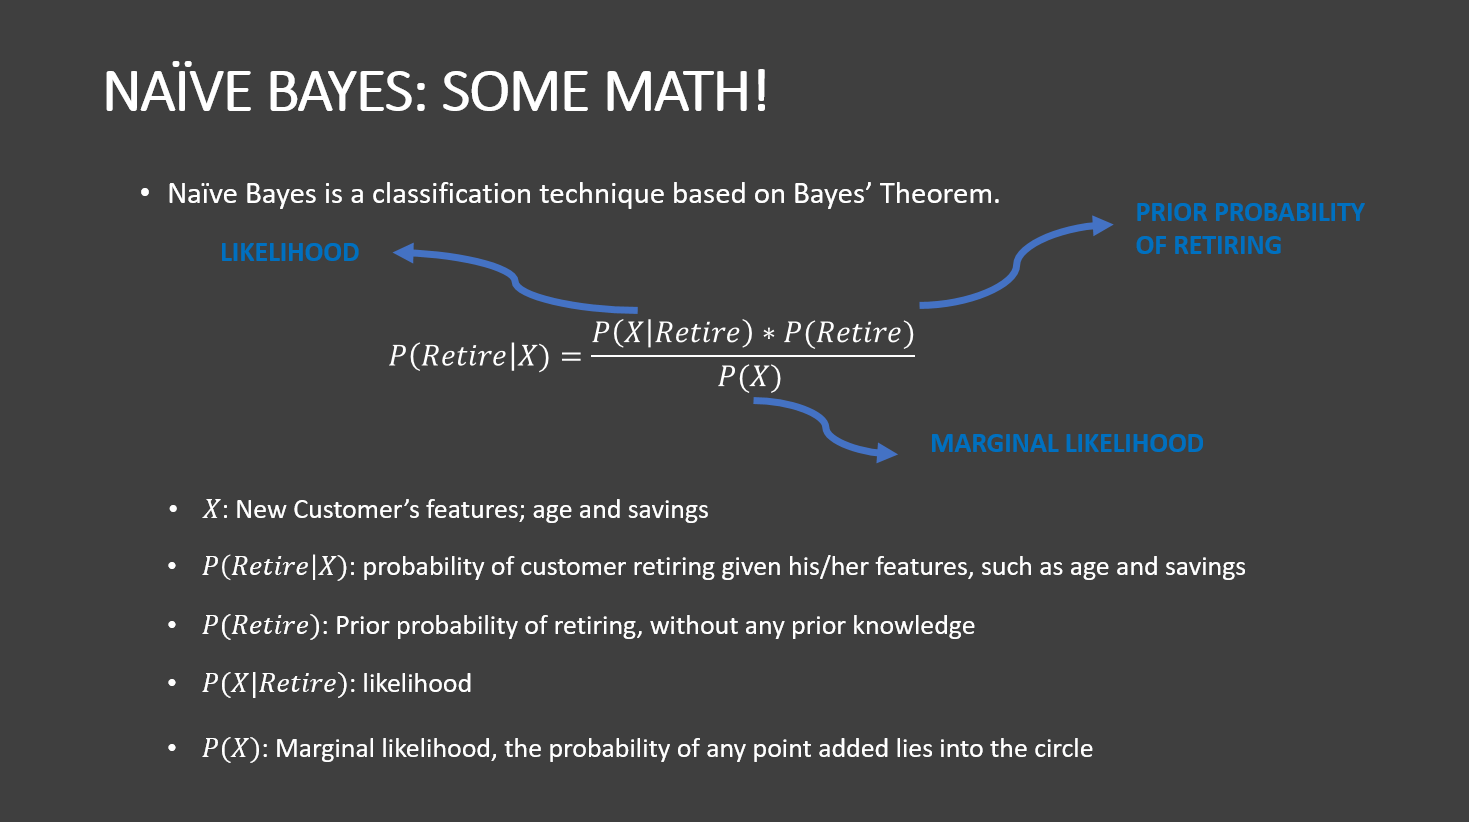

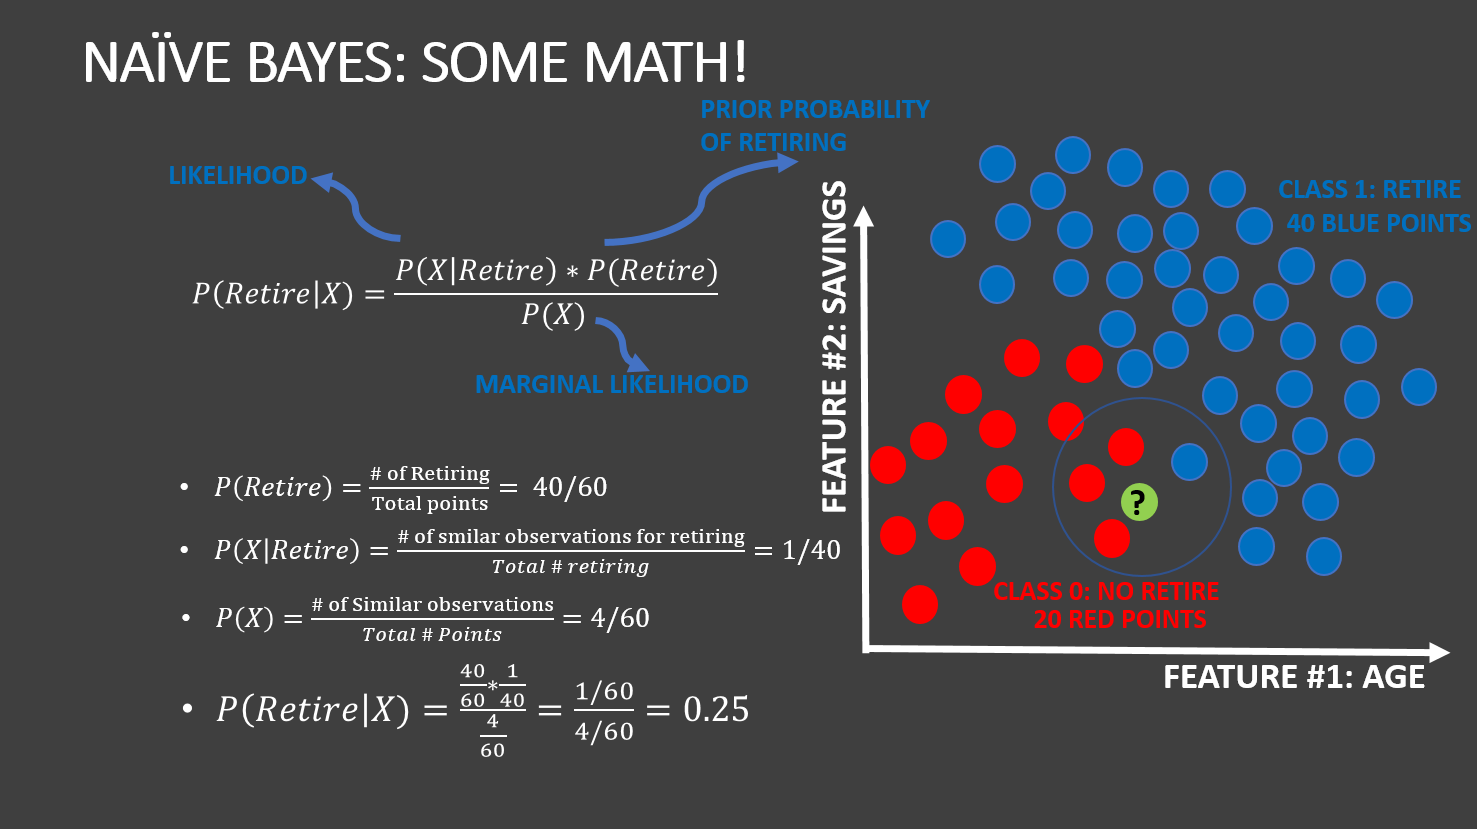

### TRAIN NAIVE BAYES CLASSIFIER MODEL

In [31]:
X = countvectorizer

In [32]:
y = resume_df['class']

In [33]:
X.shape

(125, 11315)

In [34]:
y.shape

(125,)

In [36]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [39]:
from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
NB_classifier.fit(x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MINI CHALLENGE #5:
- Split the data into 25% testing and 75% training and perform a sanity check



In [40]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.25)

### ASSESS TRAINED MODEL PERFORMANCE


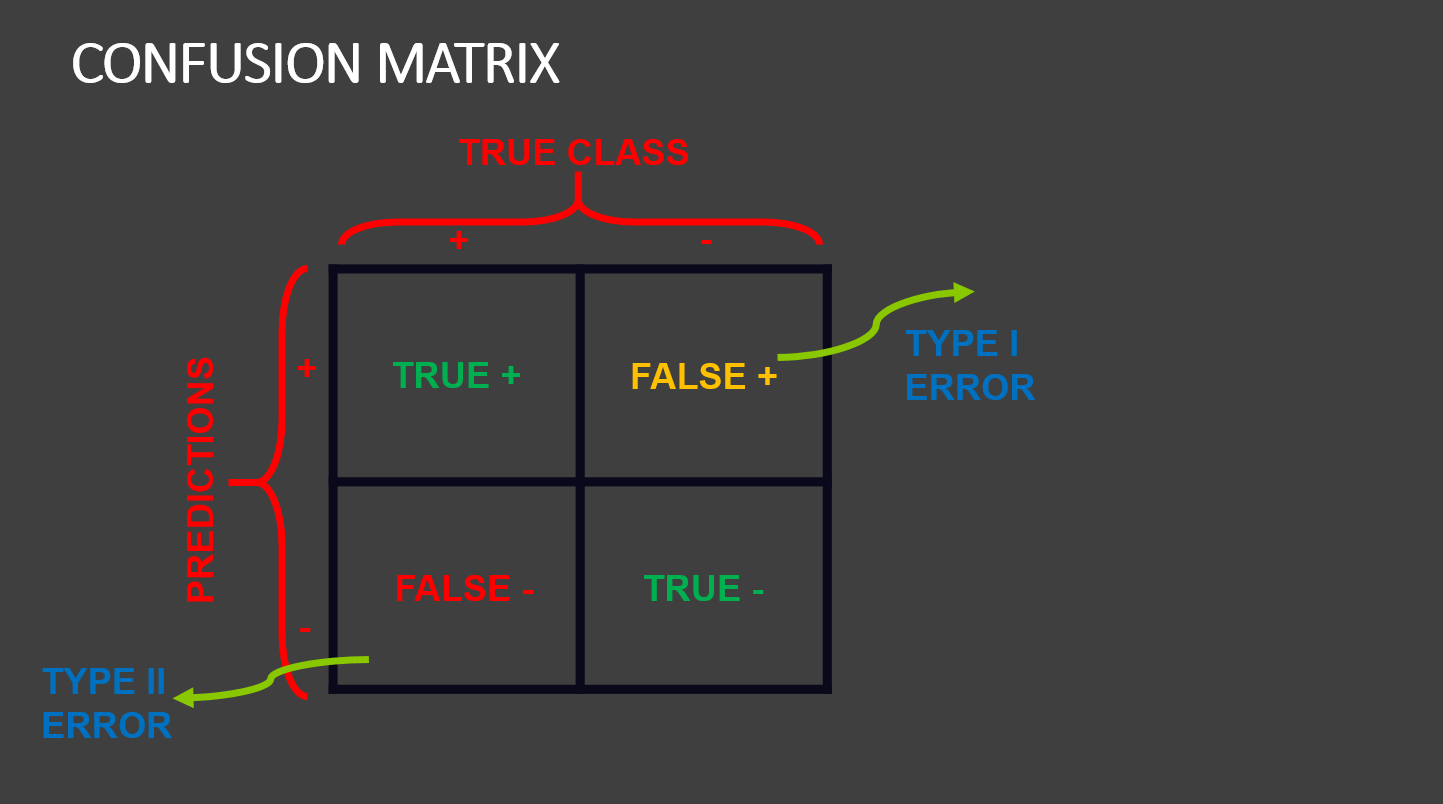

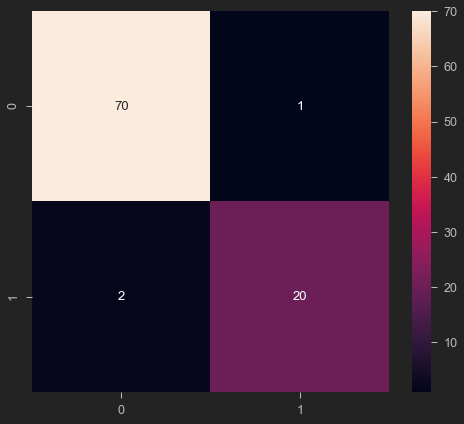

In [42]:
# Predicting the performance on train data
y_predict_train = NB_classifier.predict(x_train)
y_predict_train
cm = confusion_matrix(y_train, y_predict_train)
sns.heatmap(cm, annot = True)

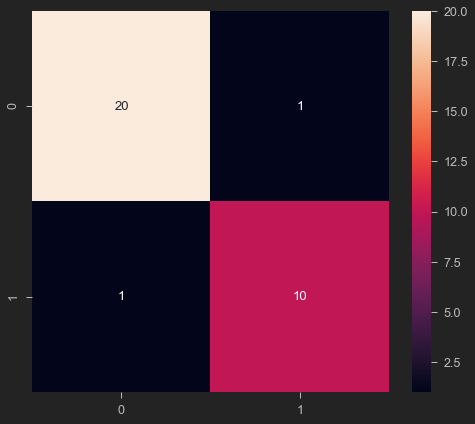

In [43]:
# Predicting the Test set results
y_predict_test = NB_classifier.predict(x_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot = True)

In [44]:
# classification report
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.91      0.91      0.91        11

    accuracy                           0.94        32
   macro avg       0.93      0.93      0.93        32
weighted avg       0.94      0.94      0.94        32

